In [1]:
import os                       # permite trabajar con archivos
import numpy as np              # Para realizar calculos matematicos y computo de datos
import pandas as pd             # para poder trabajar con dataframes
import torch                    # Pytorch
import matplotlib.pyplot as plt #  para plotear informacion sobre graficas e imagenes usando tensores
import torch.nn as nn           # Para crear redes neuronales
from torch.utils.data import DataLoader #  para realizar dataloaders
from PIL import Image           # Para checkear imagenes
import torch.nn.functional as F # para utilizar la funcion del calculo de perdida
import torchvision.transforms as transforms   # Para transformar las imagenes en tensores.
from torchvision.utils import make_grid       # Par validar la informacion
from torchvision.datasets import ImageFolder  # para trabajar con clases e imagenes
from torchsummary import summary              # Para obtener la sumarizacion de nuestros modelos

%matplotlib inline

In [2]:
# Carga de datos

data_dir = "/content/drive/MyDrive/MIT/plantas_enfermedades"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)

In [3]:
# imprime el nombre de las enfermedades
# printing the disease names
print(diseases)

['SugarCane___RedRot', 'SugarCane___RedRust', 'maiz___healthy', 'maiz___TizonHojaNorte', 'maiz___roya', 'maiz___cercospora', 'SugarCane___healthy']


In [4]:
# imprime el total de enfermedades
print("Total clase de enfermedades: {}".format(len(diseases)))

Total clase de enfermedades: 7


In [5]:
# separa los diferentes tipos de plantas y su enfermedad
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [6]:
# obtiene el nombre de las plantas analizadas.
print(f"Unique Plants are: \n{plants}")

Unique Plants are: 
['SugarCane', 'maiz']


In [7]:
# obtiene el numero de plantas unicas
print("Number of plants: {}".format(len(plants)))

Number of plants: 2


In [8]:
# numero de plantas por cada enfermedad
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))

# convierte el numero de diccionarios a pandas dataframe pasando el indice como el nombre de la planta y el numero de imagen como columna
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
SugarCane___RedRot,59
SugarCane___RedRust,60
maiz___healthy,126
maiz___TizonHojaNorte,140
maiz___roya,132
maiz___cercospora,150
SugarCane___healthy,56


Text(0.5, 1.0, 'Imagenes por cada clase de enfermedad en plantas')

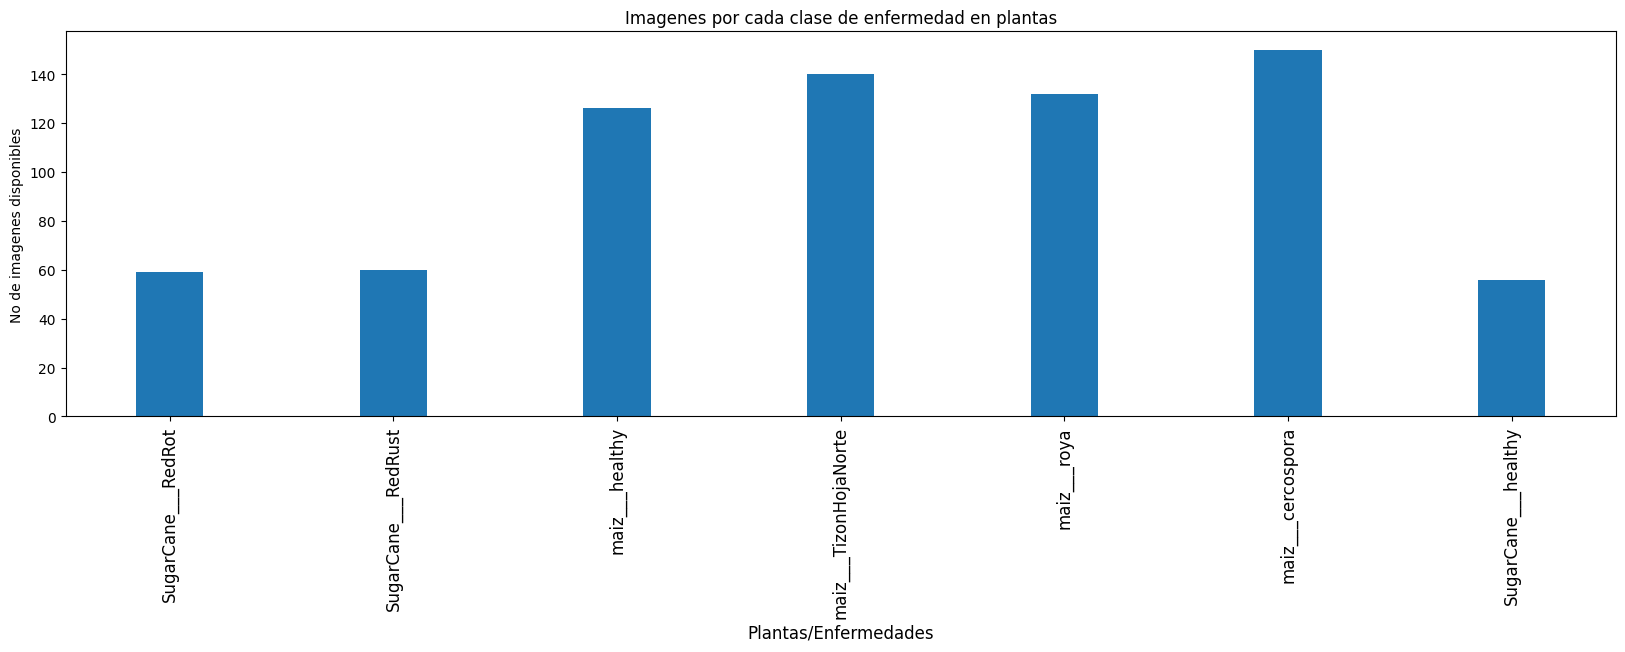

In [9]:
# Genera un histograma del numero de imagenes disponibles por cada tipo de planta
index = [n for n in range(7)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plantas/Enfermedades', fontsize=12)
plt.ylabel('No de imagenes disponibles', fontsize=10)
plt.xticks(index, diseases, fontsize=12, rotation=90)
plt.title('Imagenes por cada clase de enfermedad en plantas')

In [10]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"Existen {n_train} imagenes de entrenamiento")

Existen 723 imagenes de entrenamiento


In [11]:

transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()])

train = ImageFolder(train_dir, transform)
valid = ImageFolder(valid_dir, transform)
#train_dataset = torch.utils.data.DataLoader(image_datasets, batch_size=32,shuffle=True, num_workers=16)
# Convierte la data de entrenamiento y data de validacion en tensores.
#train = ImageFolder(train_dir, transform=transforms.ToTensor())
#valid = ImageFolder(valid_dir, transform=transforms.ToTensor())



In [12]:
# Muestra el tamaño de la primer imagen de entrenamiento
img, label = train[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


In [13]:
# Numero total de clases en el entrenamiento
len(train.classes)

7

In [14]:
# para validar algunas imagnes del dataset de entrenamiento
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))



Label :SugarCane___RedRot(0)


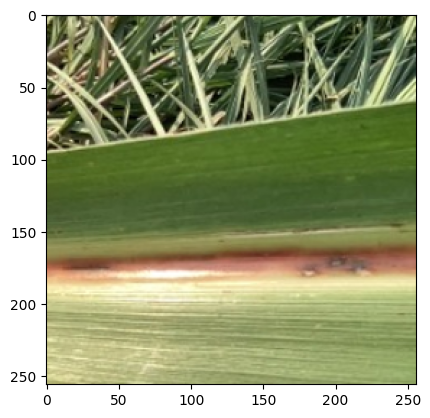

In [15]:
# muestra la imagen 1 del set de entrenamiento
show_image(*train[0])

Label :maiz___TizonHojaNorte(3)


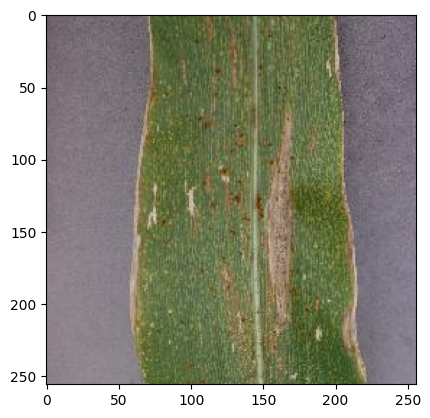

In [16]:
# muestra la imagen 70000 del set de entrenamiento
show_image(*train[200])

Label :maiz___healthy(5)


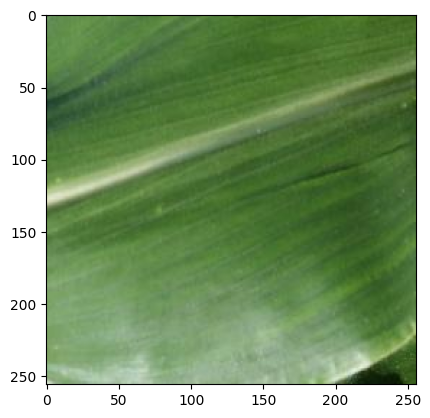

In [17]:
# muestra la imagen 30000 del set de entrenamiento
show_image(*train[500])

In [18]:

# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)



In [19]:
# Se setea el numero de lote de propagacion dentro del modelo
# en este caso se propagaran 32 imagenes a la vez para entrenar el modelo
batch_size = 32

In [20]:
# DataLoaders para entrenamiento y validacion
# dataloader ayuda a cargar datos grandes que consumen mucha memoria
# shuffle = true revuelve los datos para que no tengan parecido unos con otros
# num_workers ayuda a utilizar procesos en paralelo en este caso se configuro a 2 procesadores para trabajar en paralelo y reducir tiempo de procesamiento
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)


In [21]:
# Muestra un conjunto de imagenes de entranamiento
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

In [22]:
# Moviendo los datos a la GPU disponible
def get_default_device():
    """Toma la GPU disponible sino utiliza la CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# Muevo los datos al dispositivo disponible (CPU o GPU)
def to_device(data, device):
    """Mueve el tensor para seleccionar el dispositivo"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Carga al dispositivo (GPU si esta disponible sino CPU)
class DeviceDataLoader():
    """utiliza el cargador de datos para moverlos al dispositivo"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Genera un lote de datos luego de moverlo al dispositivo"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Numero de lotes"""
        return len(self.dl)

In [23]:
device = get_default_device()
device

device(type='cuda')

In [24]:
# trasladando los datos a la GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [25]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [26]:
# Para calcular the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Genera la prediccion
        loss = F.cross_entropy(out, labels) # Calcula la perdida
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Genera la prediccion
        loss = F.cross_entropy(out, labels)  # Calcula la perdida
        acc = accuracy(out, labels)          # Calcula la eficiencia
        return {"val_loss": loss.detach(), "val_accuracy": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # combina la perdida
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # combina la eficiencia

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [27]:
# Arquitectura de entrenamiento

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4)) #4
    return nn.Sequential(*layers)


# Arquitectura RESNET
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()

        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # Dimension de salida  : 128 x 64 x 64
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))

        self.conv3 = ConvBlock(128, 256, pool=True) # dimension de salida : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # dimension de salida : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

        #4
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))

    def forward(self, xb): # XB es el lote de carga
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [28]:
# Se crea el modelo y se mueve dentro de la GPU
model = to_device(ResNet9(3, len(train.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [29]:
# Obtiene el resumen del modelo
INPUT_SHAPE = (3, 256, 256) #256,256
print(summary(model.cuda(), (INPUT_SHAPE)))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

In [30]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))


    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()


        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [31]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 3.56 s, sys: 269 ms, total: 3.83 s
Wall time: 1min 20s


[{'val_loss': tensor(1.9358, device='cuda:0'), 'val_accuracy': tensor(0.1979)}]

In [32]:
# se configuran los hiperparametros
epochs = 3
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [33]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl, grad_clip=grad_clip, weight_decay=1e-4, opt_func=opt_func)



Epoch [0], last_lr: 0.00994, train_loss: 1.4029, val_loss: 9.8084, val_acc: 0.3464
Epoch [1], last_lr: 0.00463, train_loss: 0.7016, val_loss: 0.8974, val_acc: 0.7409
Epoch [2], last_lr: 0.00000, train_loss: 0.3010, val_loss: 0.1527, val_acc: 0.9388
CPU times: user 16.1 s, sys: 7.39 s, total: 23.5 s
Wall time: 1min 41s


In [34]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

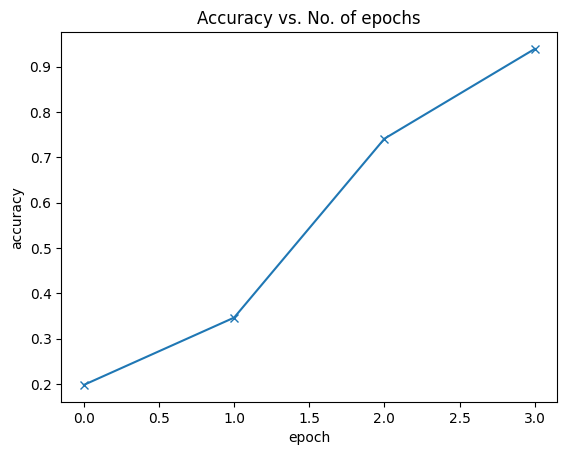

In [35]:
# se grafico la eficiancia del modelo
plot_accuracies(history)

TypeError: ignored

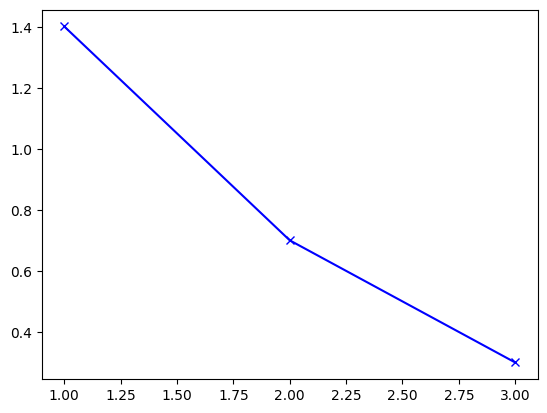

In [36]:
# se grafico la perdida
plot_losses(history)

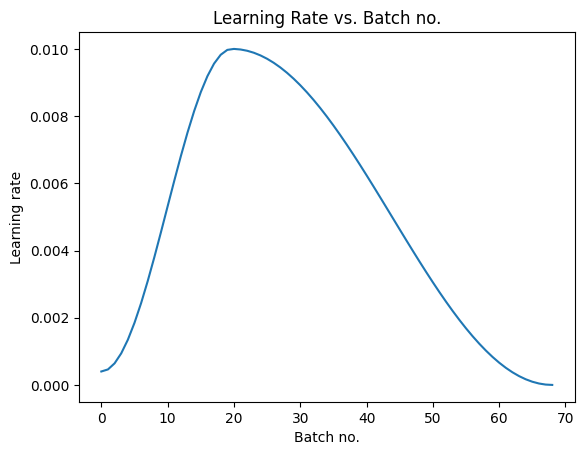

In [37]:
# se grafica el learning reate
plot_lrs(history)

In [71]:
# Se prueba el modelo con la data de prueba

test_dir = "/content/drive/MyDrive/MIT/plantas_enfermedades/test/test"
test = ImageFolder(test_dir, transform=transforms.ToTensor())

root = '/content/drive/MyDrive/MIT/plantas_enfermedades/test/test'

# create an instance of the ImageFolder class
dataset = ImageFolder(root)

# get the number of samples
num_samples = len(dataset)
print('Number of samples:', num_samples)

# get the classes
classes = dataset.classes
print('Classes:', classes)

# get the first sample
x, y = dataset[0]
print('Sample label:', x.show)


Number of samples: 4
Classes: ['Maiz', 'SugarCane']
Sample label: <bound method Image.show of <PIL.Image.Image image mode=RGB size=256x256 at 0x7A18261BBE50>>


In [89]:
test_images = sorted(os.listdir(test_dir + '/Maiz')) # since images in test folder are in alphabetical order /Producto
test_images2 = sorted(os.listdir(test_dir + '/SugarCane'))
#test_images3 = test_images.concat(test_images2)
test_images += test_images2
test_images

['CornCommonRust1.JPG',
 'CornCommonRust2.JPG',
 'CornCommonRust3.JPG',
 'SugarCaneRoyaRoja.jpg']

In [90]:
def predict_image(img, model):
    """Convierte las images a un arreglo y retorna la clase predecida
        con alta probabilidad"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train.classes[preds[0].item()]



Label: CornCommonRust1.JPG , Predicted: maiz___roya


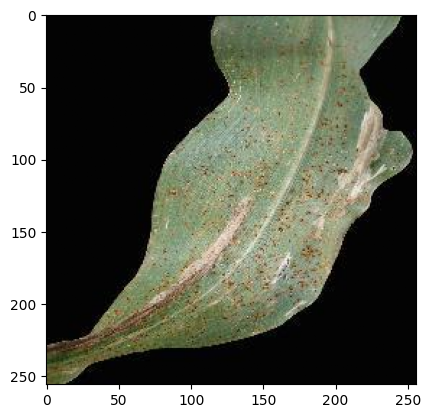

In [91]:
# Primera prediccion
img, label = test[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[0], ', Predicted:', predict_image(img, model))



Label: CornCommonRust1.JPG , Predicted: maiz___roya
Label: CornCommonRust2.JPG , Predicted: maiz___roya
Label: CornCommonRust3.JPG , Predicted: maiz___roya
Label: SugarCaneRoyaRoja.jpg , Predicted: SugarCane___RedRot


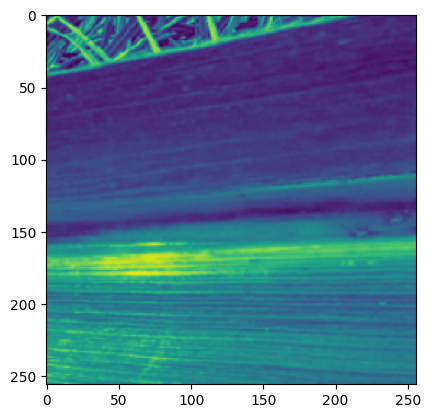

In [93]:
# getting all predictions (actual label vs predicted) enumerate(test)
#producto_dir = "/content/drive/MyDrive/MIT/plantas_enfermedades/test/test"
#Productos = ImageFolder(producto_dir)
#lista_productos = os.listdir(producto)
#numero_archivos = len(lista_productos)
#print(numero_archivos)

for i, (img, label) in enumerate(test):
    plt.imshow(img[i-1])
    print('Label:', test_images[i], ', Predicted:', predict_image(img, model))

#for i, (img, label) in enumerate(test):
#    plt.imshow(img[i-1])
#    show_image()
#    print('Label:', label, ', Predicted:', predict_image(img, model))

